In [1]:
import os
import random
import cv2
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image

In [126]:
# mndata = MNIST("rawdata")
# test_data = mndata.load_testing()
# for i,item in enumerate(zip(test_data[0],test_data[1])):

#     image,label = item
#     img = Image.fromarray(np.asarray(image).reshape((28,28))*255).resize((IMG_SIZE,IMG_SIZE))
#     img.save(f'data/test/img_{label}_{i}.png')

In [2]:
FOLDER = 'data'
BATCH_SIZE = 16
EPOCHS = 10
LR = 0.001
IMG_SIZE = 32


img_transform = transforms.Compose([
    transforms.RandomCrop(int(0.8*IMG_SIZE)),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomAffine(degrees=30,translate=(0.1,0.1),scale=(0.8,1.2)),
    transforms.ToTensor(),
])

In [3]:
class ImageDataset(Dataset):

    def __init__(self,folder,transform=None,test=False,display=None):
        
        self.folder = folder
        self.traintest = "test" if test else "train"
        self.data = os.listdir(f'data/{self.traintest}')
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()])
        
        self.display = display
        
        if self.display != None:
            print(f'We will only be displaying the {self.display}th element.')
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):
        
        if self.display != None:
            index = self.display
            
        item = self.data[index]
        label = int(item.split("_")[1])
        
        img = Image.open(f'data/{self.traintest}/{item}')
        
        
        if self.transform:
            image = self.transform(img)
        
        return image, label

In [5]:
dataset = ImageDataset(FOLDER,transform=img_transform,display=0)

We will only be displaying the 0th element.


In [6]:
dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


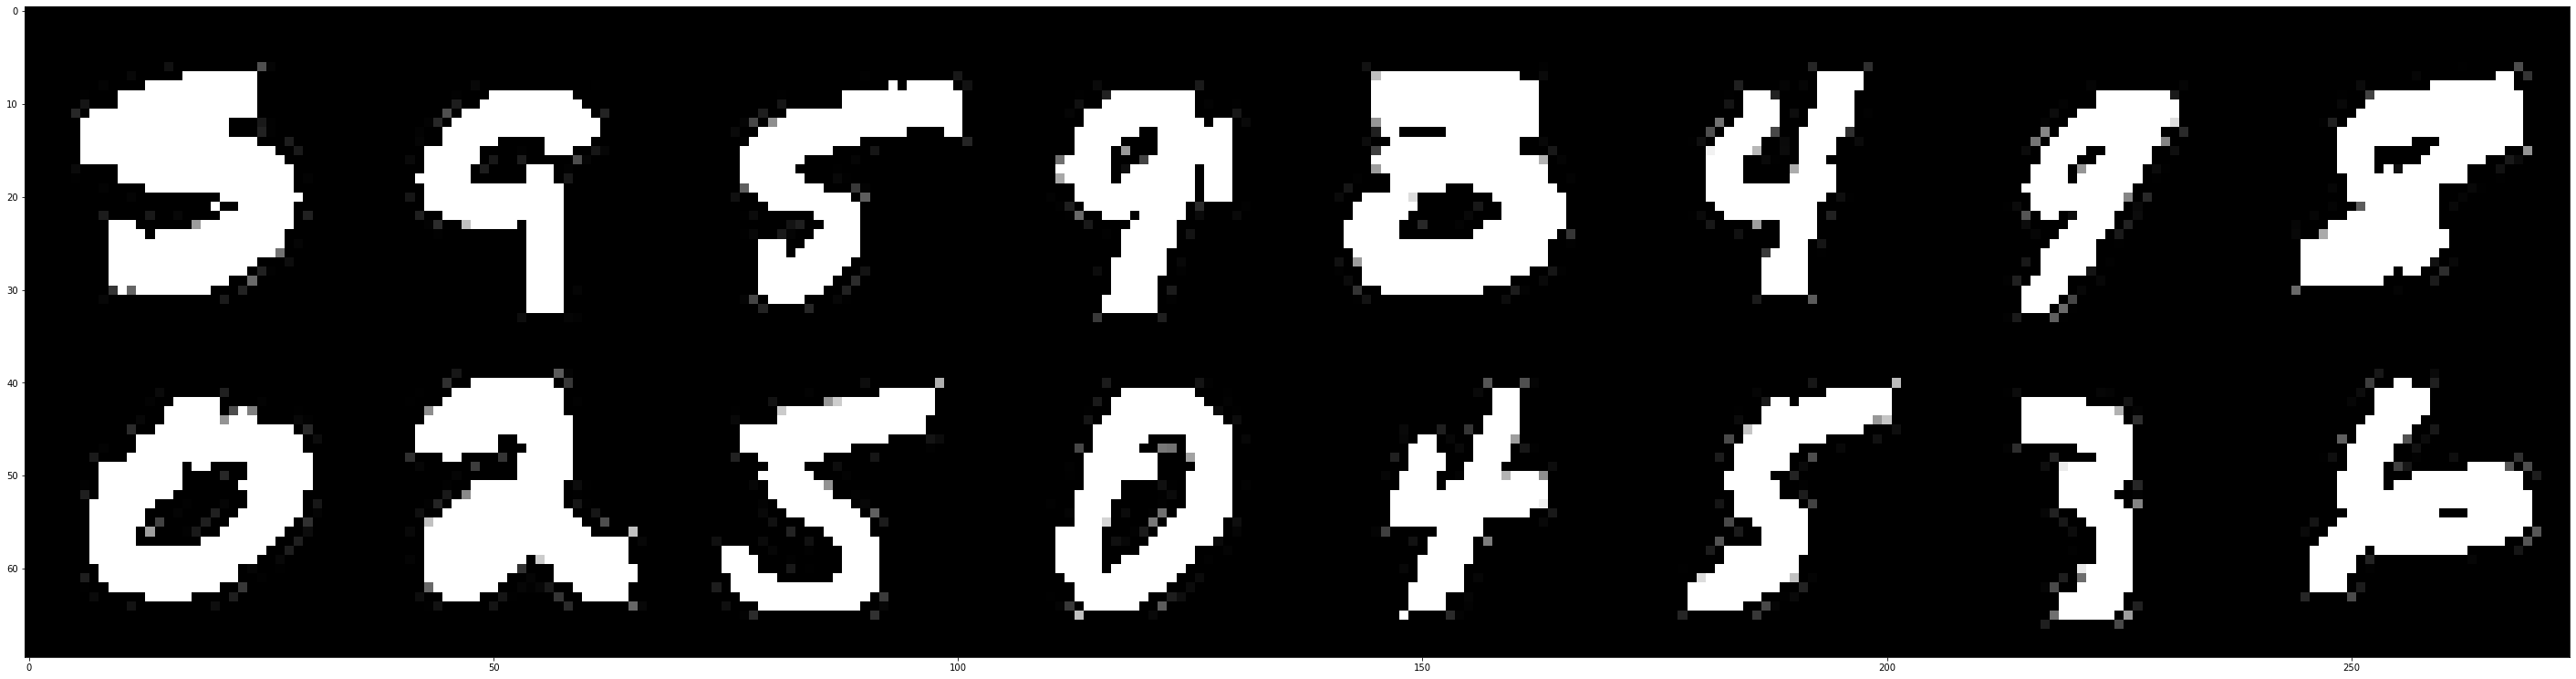

In [132]:
images,labels = next(iter(dataloader))
grid = torchvision.utils.make_grid(images,nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(grid.numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


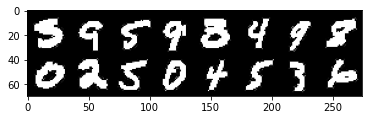

In [134]:
plt.imshow(grid.numpy().transpose(1,2,0))

In [69]:
class CNN(nn.Module):
    def __init__(self,channels,classes):
        super().__init__()
        
        
        self.Resnet1 = nn.Sequential(
            nn.Conv2d(channels,4,3,padding=1)
            ,nn.ReLU()
            ,nn.Conv2d(4,8,3,padding=1)
            ,nn.ReLU()
            )
        
        self.Resnet2 = nn.Sequential(
            nn.Conv2d(8,16,3,padding=1)
            ,nn.ReLU()
            ,nn.Conv2d(16,32,3,padding=1)
            ,nn.ReLU()
            )
        
        self.Resnet3 = nn.Sequential(
            nn.Conv2d(32,32,3,padding=1)
            ,nn.ReLU()
            ,nn.Conv2d(32,32,3,padding=1)
            ,nn.ReLU()
            )
        
        self.Encoder = nn.Sequential(
            nn.Conv2d(32,16,3,stride=2,padding=1)
            ,nn.ReLU()
            ,nn.MaxPool2d(2,2)
            ,nn.Conv2d(16,8,3,stride=2,padding=1)
            ,nn.ReLU()
            ,nn.Conv2d(8,4,3,stride=2,padding=1)
            )
        
        self.Classifier = nn.Sequential(
            nn.Linear(16,classes)
            )
         

    def forward(self, x):
        
        x = self.Resnet1(x)
        x = self.Resnet2(x)
        x = self.Resnet3(x)
        x = self.Encoder(x)
        x = x.reshape(-1,16)
        x = self.Classifier(x)
        
        return x

In [70]:
dataset = ImageDataset(FOLDER)
dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
    )

In [71]:
model = CNN(1,10).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR,
                             weight_decay=1e-5)

In [72]:
losses = []

for e in tqdm(range(EPOCHS)):
    total_loss = 0
    for images,labels in dataloader:

        optimizer.zero_grad()

        output = model(images.float().to("cuda"))
        loss = criterion(output,labels.to("cuda"))
        loss.backward()
        optimizer.step()

        total_loss += loss.detach().cpu()
        
    losses.append(total_loss/len(dataloader))
 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:23<00:00, 38.36s/it]


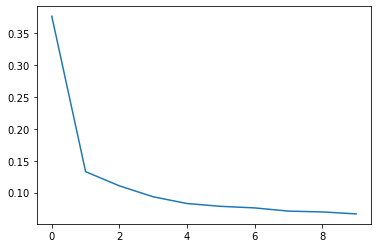

In [73]:
plt.plot(losses);

In [74]:
# torch.save(model.state_dict(),"models/cnn1.pkl")

In [75]:
# model = CNN(1,10).to("cuda")
# model.load_state_dict(torch.load("models/cnn1.pkl"))

<All keys matched successfully>

In [76]:
testset = ImageDataset(FOLDER,test=True)
testloader = DataLoader(
    testset, 
    batch_size=200,
    shuffle=True
    )

In [142]:
images,labels = next(iter(testloader))

In [78]:
with torch.no_grad():
    predictions = model(images.float().to("cuda")).cpu()

In [79]:
np.where(labels==predictions.argmax(axis=1),1,0).sum()/200

0.99

<AxesSubplot:>

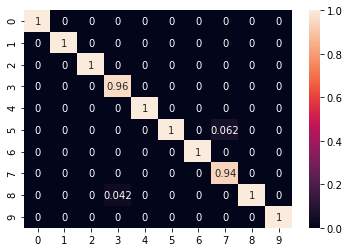

In [80]:
sns.heatmap(confusion_matrix(labels,predictions.argmax(axis=1),normalize="pred"),annot=True)

In [81]:
print(classification_report(labels,predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        18
           3       0.96      1.00      0.98        23
           4       1.00      1.00      1.00        29
           5       1.00      0.94      0.97        17
           6       1.00      1.00      1.00        18
           7       0.94      1.00      0.97        15
           8       1.00      0.93      0.97        15
           9       1.00      1.00      1.00        21

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



In [82]:
values = []
gt = []
for i in range(10):
    samples = images[labels==i].clone()
    values.append(samples)
    gt += [i for _ in range(len(samples))]

In [83]:
outputs = []
with torch.no_grad():
    for i in range(10):
        outputs.append(model.Encoder(model.Resnet2(model.Resnet1(values[i].float().to("cuda")))).reshape(-1,16).cpu())

In [84]:
ls = outputs[0]
for i in range(9):
    ls = torch.cat((ls,outputs[i+1]))

In [85]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [86]:
lda = LinearDiscriminantAnalysis(n_components=3)

In [87]:
df = pd.DataFrame(lda.fit_transform(ls,gt),columns=["Component 0","Component 1","Component 2"])

In [88]:
df.loc[:,"Label"] = gt

In [89]:
df.head()

,Component 0,Component 1,Component 2,Label
0,1.913420,-2.299377,-4.345894,0
1,2.632297,-3.759840,-1.578234,0
2,0.795508,-0.294916,-2.468365,0
3,-0.043979,-1.566112,-1.460553,0
4,2.516623,-0.565929,-0.619142,0


In [90]:
import matplotlib.cm as cm
from mpl_toolkits import mplot3d

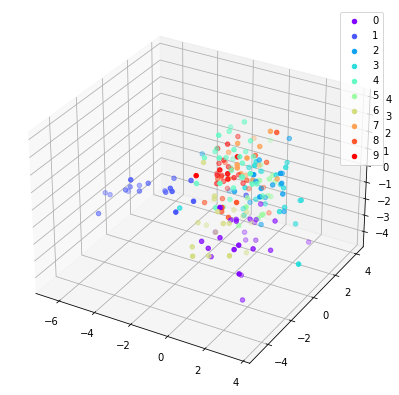

In [91]:
colors = cm.rainbow(np.linspace(0, 1, 10))
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for i in range(10):
    ax.scatter3D(df[df.Label==i].iloc[:,0],df[df.Label==i].iloc[:,1],df[df.Label==i].iloc[:,2],color=colors[i],label=f'{i}')
plt.legend();

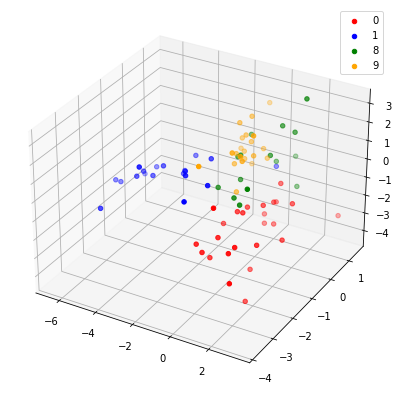

In [92]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(df[df.Label==0].iloc[:,0],df[df.Label==0].iloc[:,1],df[df.Label==0].iloc[:,2],color="r",label="0")
ax.scatter3D(df[df.Label==1].iloc[:,0],df[df.Label==1].iloc[:,1],df[df.Label==1].iloc[:,2],color="b",label="1")
ax.scatter3D(df[df.Label==8].iloc[:,0],df[df.Label==8].iloc[:,1],df[df.Label==8].iloc[:,2],color="g",label="8")
ax.scatter3D(df[df.Label==9].iloc[:,0],df[df.Label==9].iloc[:,1],df[df.Label==9].iloc[:,2],color="orange",label="9")
plt.legend();

In [93]:
def GradCAM(X,index):

    X = X[index].unsqueeze(0).float()
    # plt.imshow(X.squeeze(),cmap="gray")

    model.eval()

    # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
    X.requires_grad_()

    '''
    forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
    and we also don't need softmax, we need scores, so that's perfect for us.
    '''

    scores = model(X.to("cuda")).cpu()



    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]

    '''
    backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
    score_max with respect to nodes in the computation graph
    '''
    score_max.backward()

    '''
    Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
    R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
    across all colour channels.
    '''
    saliency, _ = torch.max(X.grad.data.abs(),dim=1)

    # code to plot the saliency map as a heatmap
    f,axi = plt.subplots(1,2)
    axi[0].imshow(X.detach().squeeze(),cmap="gray")
    axi[1].imshow(saliency.squeeze(), cmap=plt.cm.hot)
    axi[0].set_title(f'Predicted value: {score_max_index}')
    axi[1].set_title(f'True value: {labels[index]}')
    plt.axis('off')
    plt.show()
    

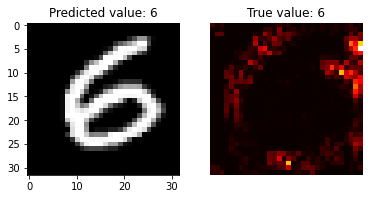

In [94]:
GradCAM(images,4)

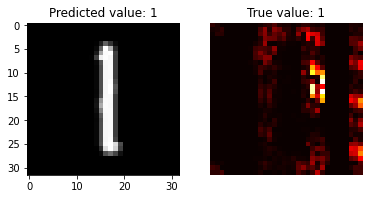

In [95]:
GradCAM(images,0)

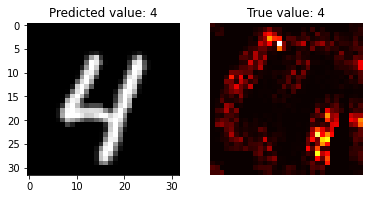

In [96]:
GradCAM(images,50)

In [97]:
with torch.no_grad():
    top_losses = torch.topk(nn.CrossEntropyLoss(reduction="none")(predictions.to("cuda"),labels.to("cuda")).cpu(),8)
top_losses[1]

tensor([ 38, 160,  88,  52, 177,  66, 186, 120])

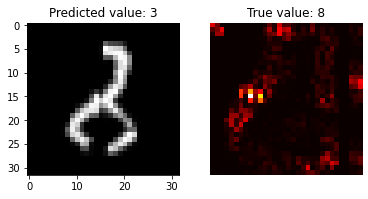

In [98]:
GradCAM(images,38)

In [174]:
with torch.no_grad():
    feature_maps = model.Resnet1(images[0].unsqueeze(0).float().to("cuda")).cpu()

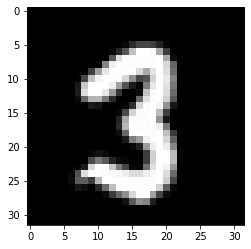

In [172]:
plt.imshow(images[0].squeeze(),cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


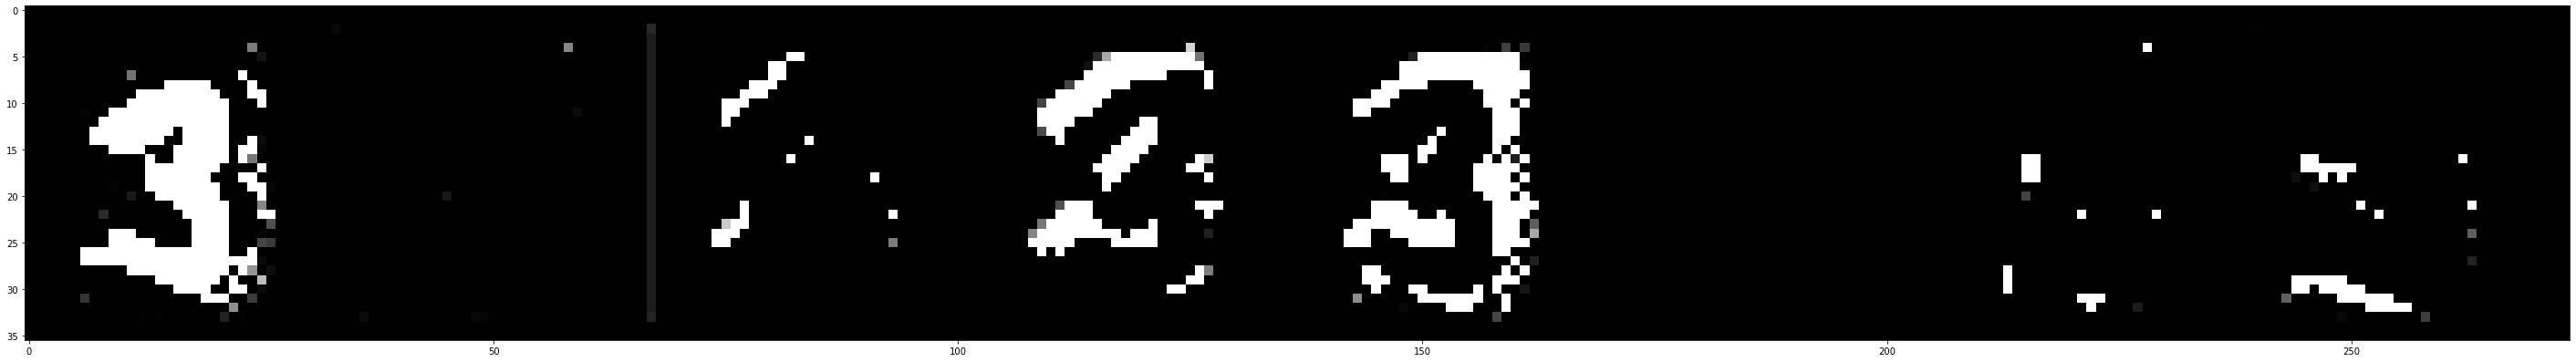

In [175]:
grid = torchvision.utils.make_grid(feature_maps.permute(1,0,2,3),nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(grid.numpy().transpose(1,2,0))

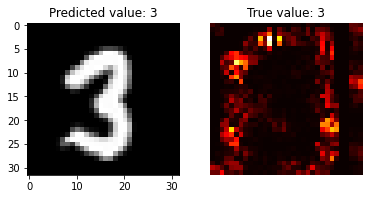

In [176]:
GradCAM(images,0)